<a href="https://colab.research.google.com/github/MnCSSJ4x/VR-MiniProject/blob/main/VR3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visual Recognition Mini Project 
###Part B: Experimenting With Transfer Learning
#### Authors:
- Rishi Vakharia: IMT2020067
- Karanjit Saha: IMT2020003
- Monjoy Narayan Choudhury: IMT2020502 


In [125]:
import torch 
from torch import optim, cuda
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

import math 
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms
from tqdm import tqdm 
import tarfile
!pip install imutils

import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import time 
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
cuda = cuda.is_available()
print(f'Train on gpu: {cuda}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Train on gpu: True


### Dataset Used 
The dataset we are planning to use is the caltech 101 dataset.  It consist of about 40 to 800 images per category. Most categories have about 50 images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc'Aurelio Ranzato. The size of each image is roughly 300 x 200 pixels. 

In [127]:
with tarfile.open('drive/MyDrive/101_ObjectCategories.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [128]:
image_paths = list(paths.list_images('/content/101_ObjectCategories'))

In [129]:
data = []
labels = []
label_names = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    label_names.append(label)
    labels.append(label)

In [130]:
data = np.array(data)
labels = np.array(labels)

<ipython-input-130-d215b55aed65>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


Labels are in string format and we need to get it to number format 

In [131]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [132]:
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


We need to do transformations on the images from this dataset as the model we are intending to use is the AlexNet model trained on ImageNet where the image is of size 224x224. We rescale the image as well as noramise it based on imagenet standards. Other than that since images per class is too low we also try some data augmentation on the train set explictly 

In [133]:
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.RandomRotation((-30, 30)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

Custom Dataset class which allows us to apply transformations and create a dataset object to pass into dataloader 

In [134]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [135]:
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

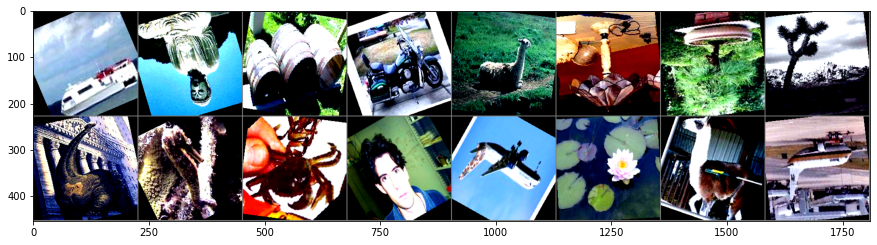

In [136]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

### Pre-trained Model Alexnet 

In [137]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [138]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [139]:
for param in model.parameters():
    param.requires_grad = False

In [140]:
model.classifier[6] = nn.Linear(in_features=4096,out_features=101,bias=True)

In [141]:
for param in model.classifier[6].parameters():
  param.requires_grad = True

In [142]:
model 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [143]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [144]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Define your loss function
criterion = nn.CrossEntropyLoss()

In [145]:
epochs = 10 

#### Training and Validation 

In [146]:
def fit(model, dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [147]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [148]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples")
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

Training on 5205 examples, validating on 1736 examples
Epoch 1 of 10
Training


326it [00:19, 17.03it/s]                         


Train Loss: 0.7838, Train Acc: 50.72
Validating


109it [00:04, 22.91it/s]                         


Val Loss: 0.5817, Val Acc: 69.93
Epoch 2 of 10
Training


326it [00:27, 12.05it/s]                         


Train Loss: 0.6159, Train Acc: 66.46
Validating


109it [00:04, 22.92it/s]                         


Val Loss: 0.5796, Val Acc: 72.93
Epoch 3 of 10
Training


326it [00:18, 17.84it/s]


Train Loss: 0.5050, Train Acc: 73.12
Validating


109it [00:04, 23.24it/s]                         


Val Loss: 0.6116, Val Acc: 72.93
Epoch 4 of 10
Training


326it [00:18, 18.02it/s]                         


Train Loss: 0.4841, Train Acc: 75.27
Validating


109it [00:05, 21.21it/s]


Val Loss: 0.6216, Val Acc: 75.92
Epoch 5 of 10
Training


326it [00:17, 18.52it/s]                         


Train Loss: 0.4248, Train Acc: 78.50
Validating


109it [00:05, 19.48it/s]                         


Val Loss: 0.6791, Val Acc: 75.52
Epoch 6 of 10
Training


326it [00:17, 18.62it/s]                         


Train Loss: 0.3902, Train Acc: 80.33
Validating


109it [00:05, 21.08it/s]


Val Loss: 0.6799, Val Acc: 76.04
Epoch 7 of 10
Training


326it [00:18, 17.85it/s]                         


Train Loss: 0.3635, Train Acc: 81.98
Validating


109it [00:04, 22.74it/s]                         


Val Loss: 0.7550, Val Acc: 75.69
Epoch 8 of 10
Training


326it [00:18, 17.62it/s]                         


Train Loss: 0.4055, Train Acc: 81.73
Validating


109it [00:05, 19.59it/s]                         


Val Loss: 0.7451, Val Acc: 77.25
Epoch 9 of 10
Training


326it [00:18, 17.87it/s]                         


Train Loss: 0.3775, Train Acc: 82.98
Validating


109it [00:04, 22.93it/s]                         


Val Loss: 0.7800, Val Acc: 76.84
Epoch 10 of 10
Training


326it [00:17, 18.44it/s]                         


Train Loss: 0.3515, Train Acc: 83.63
Validating


109it [00:05, 19.56it/s]

Val Loss: 0.8473, Val Acc: 76.38
4.022642644246419 minutes


###Train vs Val 

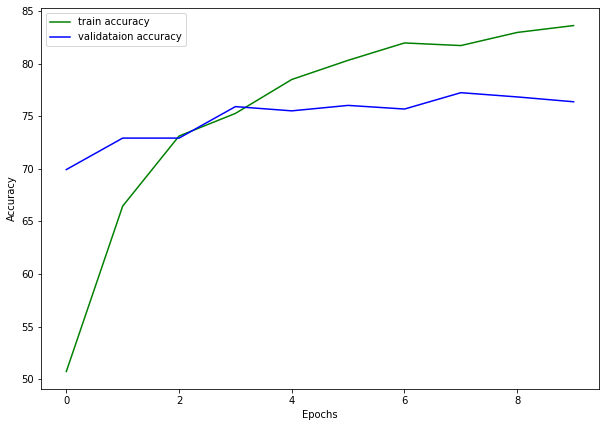

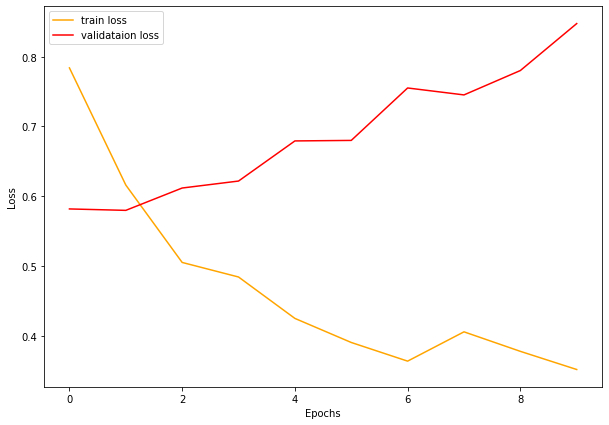

In [149]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

### Test

In [150]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (
    100 * correct / total))

Accuracy of the network on test images: 75.058 %
